Title 

Intro

Methods and Results code 

Can a player's total played hours and experience level, predict whether they subscribe to the game-related newsletter?


In [4]:
library(tidyverse)
players <- read_csv("https://raw.githubusercontent.com/edoardo-antonucci/Data-Science-Project-Planning-Stage-Individual-/main/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [6]:
players_tidy <- players |>
  select(experience, played_hours, subscribe) |>
  mutate(experience = as.factor(experience))

head(players_tidy)

experience,played_hours,subscribe
<fct>,<dbl>,<lgl>
Pro,30.3,TRUE
Veteran,3.8,TRUE
Veteran,0.0,FALSE
Amateur,0.7,TRUE
Regular,0.1,TRUE
Amateur,0.0,TRUE


In [8]:
summarise(players_tidy, mean_hours = mean(played_hours, na.rm = TRUE))

mean_hours
<dbl>
5.845918


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


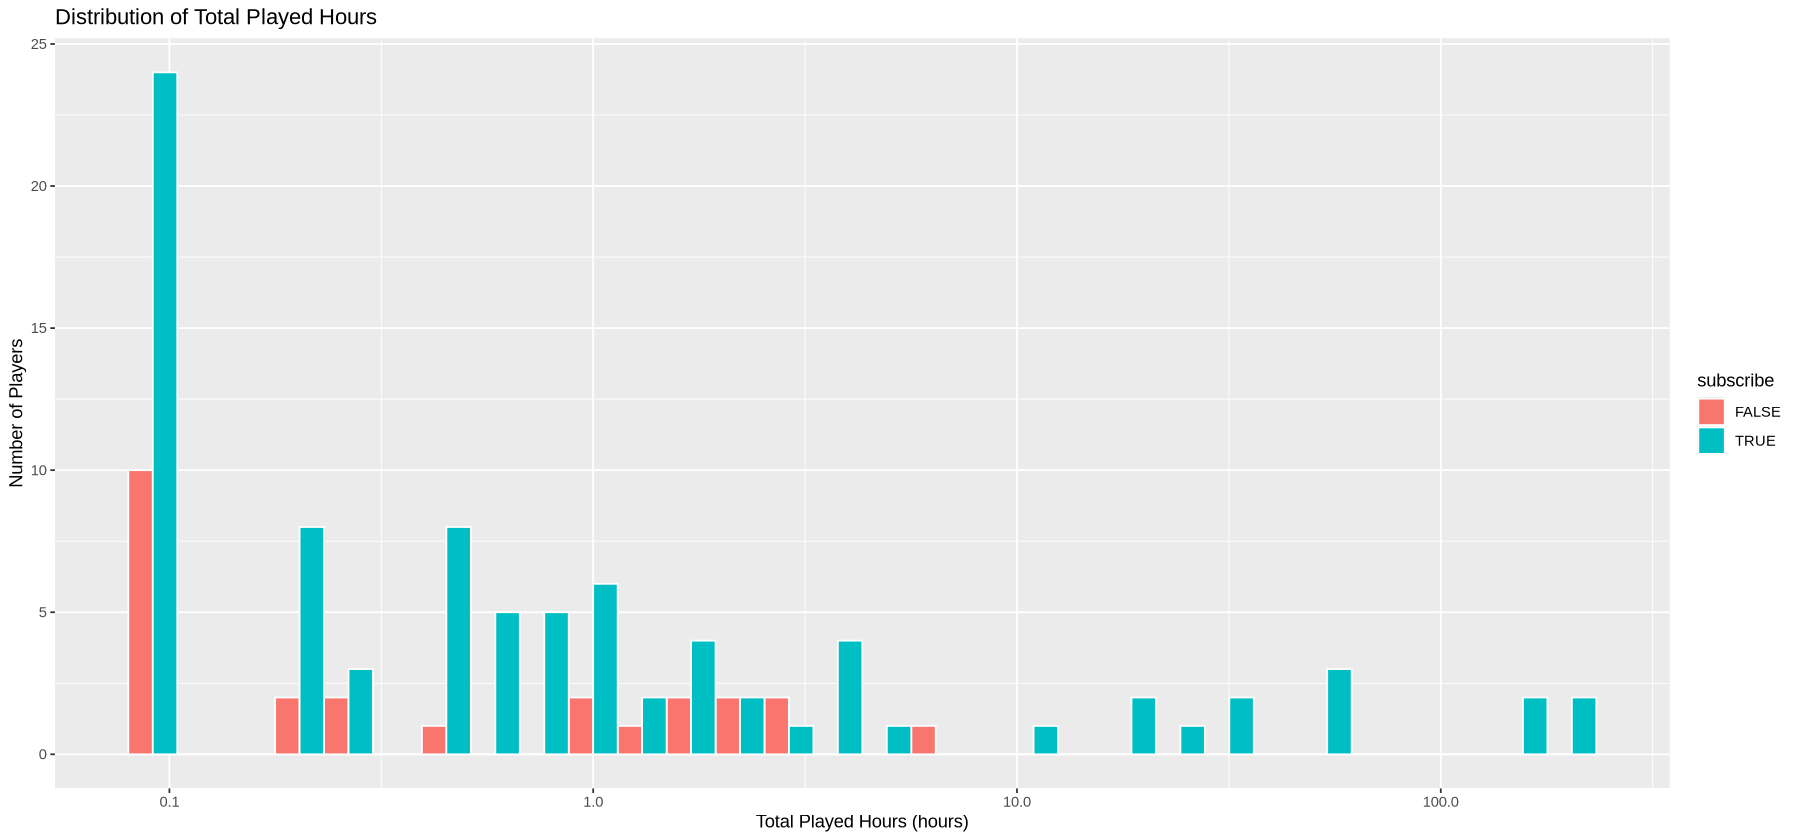

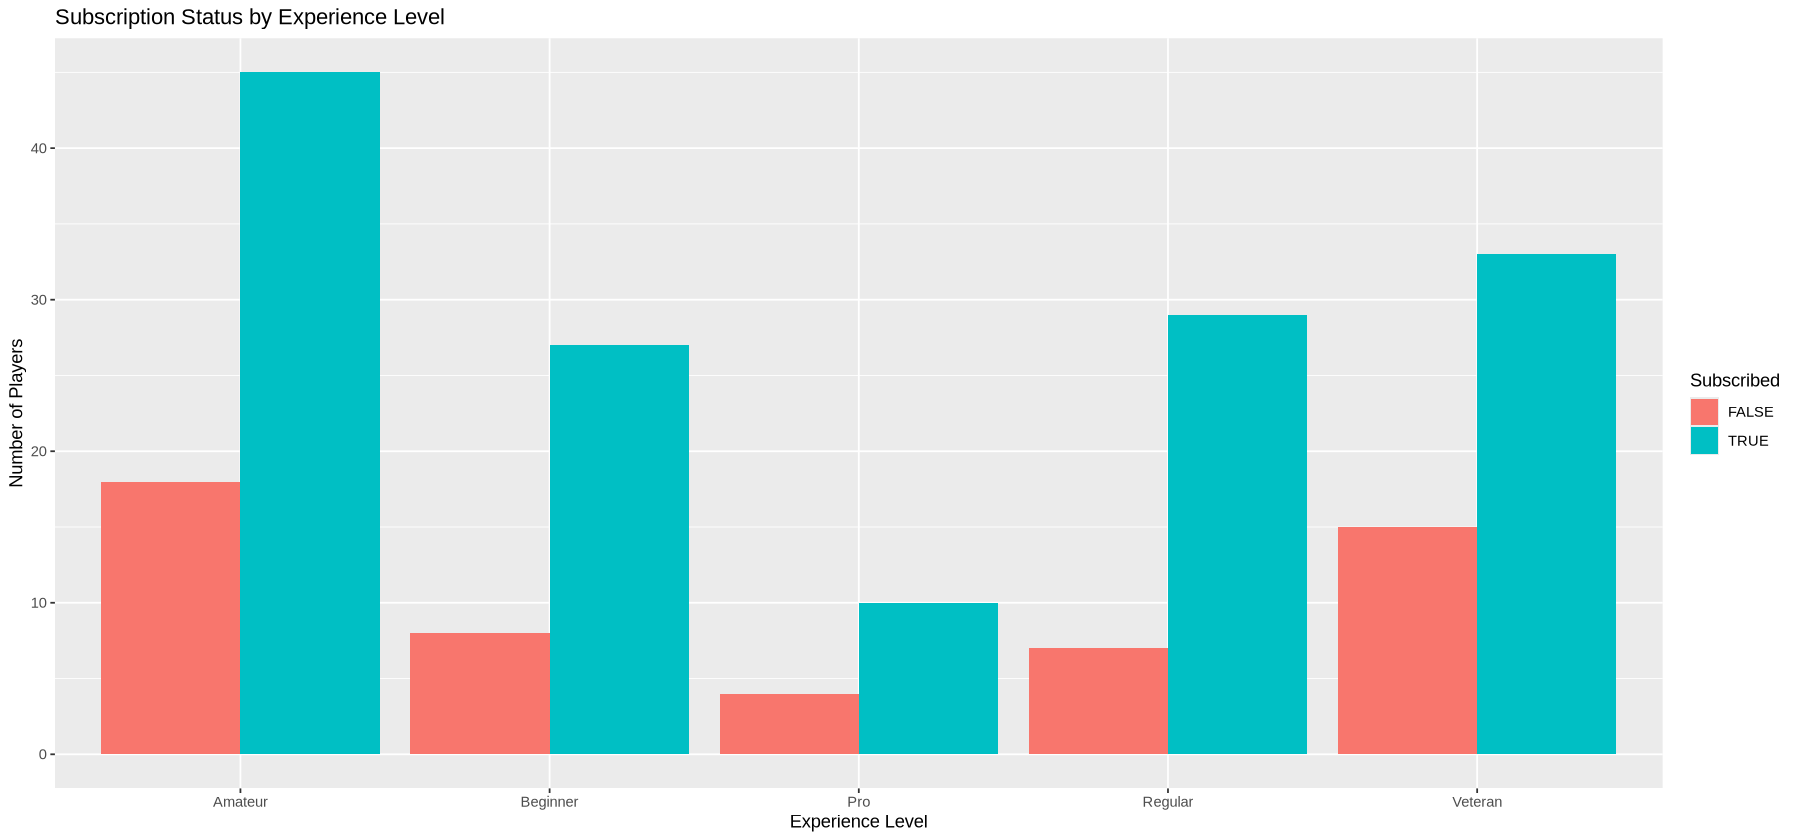

In [17]:
options (repr.plot.width = 15)

# Distribution of Total Played Hours
total_hours_plot <- ggplot(players_tidy, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(color = "white",position = "dodge") +
  scale_x_log10 ()+
  labs(
    title = "Distribution of Total Played Hours",
    x = "Total Played Hours (hours)",
    y = "Number of Players", 
    fill = "subscribe"
  )
total_hours_plot
# Subscription status vs Experience Level
ph_vs_ns <- ggplot(players_tidy, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Subscription Status by Experience Level",
    x = "Experience Level",
    y = "Number of Players",
    fill = "Subscribed"
  )
ph_vs_ns

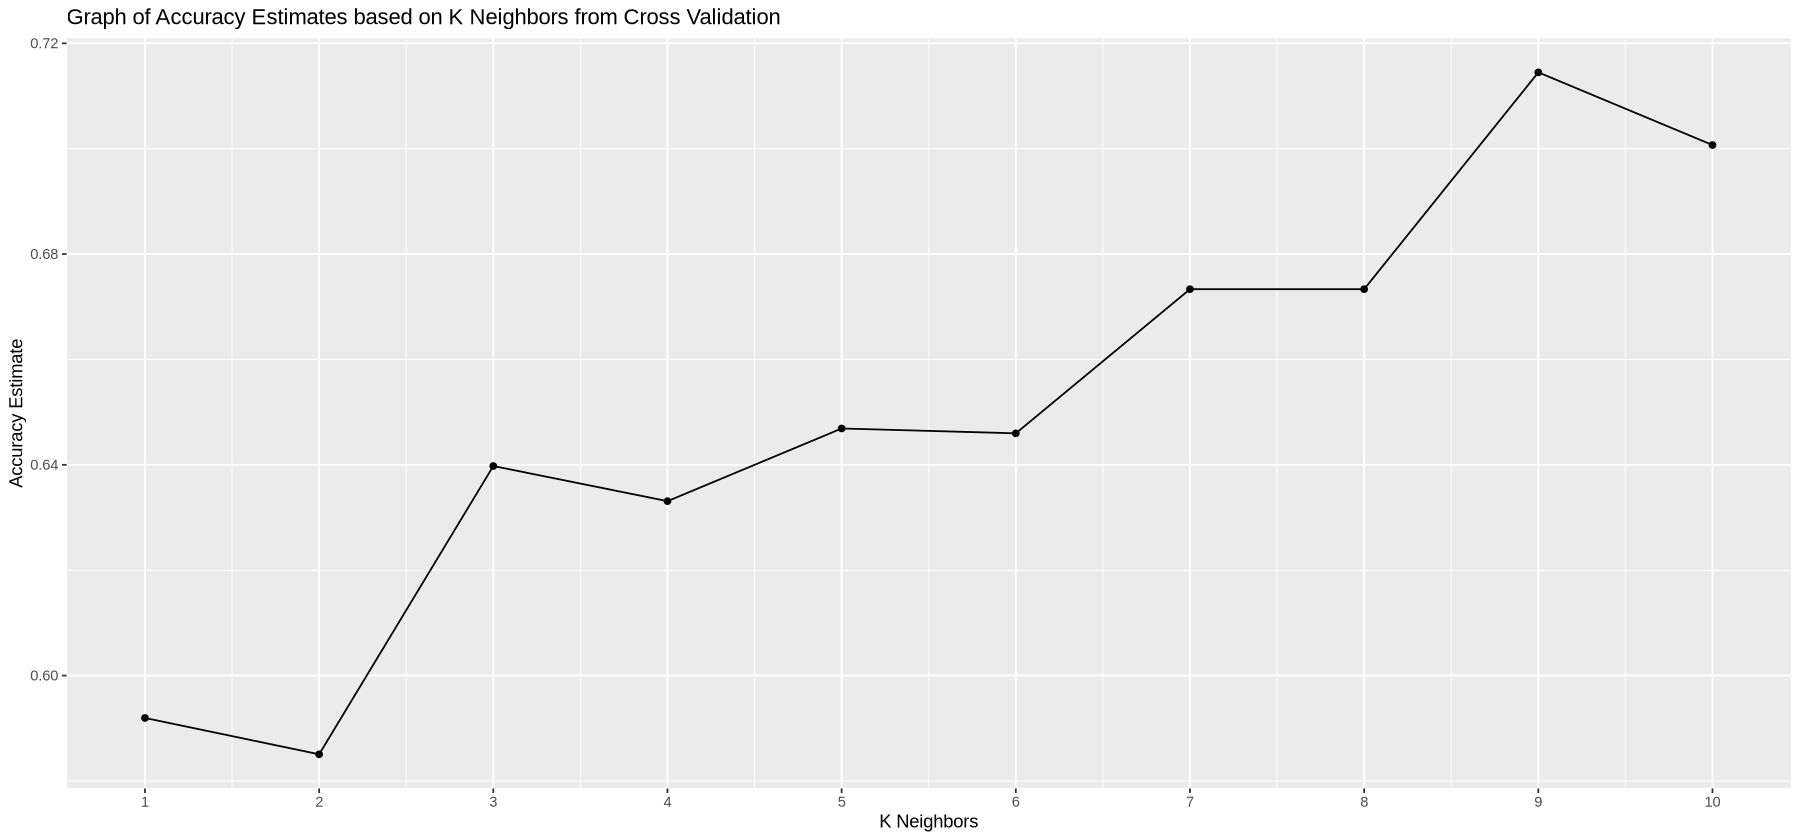

In [28]:
set.seed(1) 
library(tidymodels)

players_tidy <- players_tidy |>
mutate(subscribe = as_factor(subscribe))


initial_split <- initial_split(players_tidy, prop = 0.75)
training_data <- training(initial_split)
testing_data <- testing(initial_split)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_recipe <- recipe(subscribe ~ played_hours + experience, data = training_data)

players_vfold <- vfold_cv(training_data, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

players_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- players_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous (breaks = seq ( 1, 10, by = 1)) + 
    labs(x="K Neighbors", y = "Accuracy Estimate") +
    ggtitle("Graph of Accuracy Estimates based on K Neighbors from Cross Validation")

cross_val_plot